# IMDB 영화리뷰 감정분석
tensorflow Keras에 포함된 imdb 데이터셋을 분석


---

### 1. 데이터셋 불러오기

In [17]:
import numpy as np
import os

In [2]:
import tensorflow as tf

In [3]:
imdb = tf.keras.datasets.imdb

# IMDb 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

훈련 샘플 개수: 25000, 테스트 개수: 25000


In [4]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

# 데이터 확인

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


결과를 보면 이미 숫자로 encode된 데이터임을 알 수 있음.<br>
imdb 데이터셋은 encode한 데이터와 딕셔너리를 함께 제공함.(단어 출현 빈도 기준으로 내림차순 정렬)<br><br>


### 1-2. 딕셔너리 확인 

In [5]:
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # 'the' 가 출력됨. 
print(word_to_index['the'])  # 1 이 출력됨.

the
1


In [6]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀어서 사용하였음.
#따라서 PAD, BOS, UNK, 추가로 UNUSED까지 넣어주는 작업을 할 것.
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됨. 
print(word_to_index['the'])  # 4 이 출력됨. 
print(index_to_word[4])     # 'the' 가 출력됨.

<BOS>
4
the


In [7]:
# 작업을 거친 딕셔너리로 제대로 디코딩이 되는지 확인

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence(x_train[0], index_to_word))
print('---')
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

### 1-3. Embedding 전 문장 길이를 일치시키기
<span style="color:red"> 문장 최대 길이 **maxlen**의 값 설정이 모델 성능에 영향을 크게 미치므로 적절한 값을 찾아야 한다. </span>
 * 적절한 maxlen값 찾기

In [8]:
total_data_text = list(x_train) + list(x_test)
# len함수를 적용하기 위해 리스트를 생성해서 데이터를 삽입

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산. 

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703


#### 여기서는 maxlen을 (평균 + 2*표준편차)로 설정할 것

In [9]:
# 최대 길이를 (평균 + 2*표준편차)로 설정,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함된다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함된다. 


위에서 정한 것처럼 maxlen = 580으로 진행<br><br>


* Padding을 적용하여 문장 길이를 일치시키기(train, test 데이터)
 
 
 
#### padding 방식을 문장 뒤쪽('post')과 앞쪽('pre') 어느 쪽으로 지정하는가에 따라 성능 차이가 발생(RNN 특성상 pre가 유리)

In [10]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


### 1-4. train 데이터셋이서 validation 데이터셋 분리
훈련 데이터 25000건에서 10000건을 분리할 예정

In [11]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


### 1-5. Embedding을 포함한 Bidirectional LSTM 모델 설계

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수(변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Metal device set to: Apple M2


2022-09-19 23:41:12.086017: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-19 23:41:12.086465: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              148480    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 308,737
Trainable params: 308,737
Non-trainable params: 0
_________________________________________________________________


### 1-6. 모델 학습 및 평가

In [23]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸기. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20


2022-09-19 22:04:17.281235: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-19 22:04:18.005687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-19 22:04:18.250519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-19 22:04:18.263866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-19 22:04:21.347027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-19 22:04:21.363653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5056

2022-09-19 22:05:04.963434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-19 22:05:05.019651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-19 22:05:05.030051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 56s 2s/step - loss: 0.6933 - accuracy: 0.5056 - val_loss: 0.6924 - val_accuracy: 0.4947
Epoch 2/20
30/30 [==============================] - 44s 1s/step - loss: 0.6761 - accuracy: 0.6114 - val_loss: 0.6247 - val_accuracy: 0.7264
Epoch 3/20
30/30 [==============================] - 41s 1s/step - loss: 0.6205 - accuracy: 0.7201 - val_loss: 0.5880 - val_accuracy: 0.6985
Epoch 4/20
30/30 [==============================] - 40s 1s/step - loss: 0.5744 - accuracy: 0.7285 - val_loss: 0.5826 - val_accuracy: 0.7013
Epoch 5/20
30/30 [==============================] - 40s 1s/step - loss: 0.4979 - accuracy: 0.7828 - val_loss: 0.4973 - val_accuracy: 0.7545
Epoch 6/20
30/30 [==============================] - 57s 2s/step - loss: 0.3530 - accuracy: 0.8469 - val_loss: 0.3962 - val_accuracy: 0.8288
Epoch 7/20
30/30 [==============================] - 60s 2s/step - loss: 0.2560 - accuracy: 0.8956 - val_loss: 0.3585 - val_accuracy: 0.8481
Epoch 8/20
30/30 [=============

#### 테스트 데이터셋을 이용해 평가

In [24]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 102s - loss: 6.9752 - accuracy: 0.5019 - 102s/epoch - 130ms/step
[6.975229740142822, 0.5019200444221497]


#### train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있으므로 확인

In [25]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


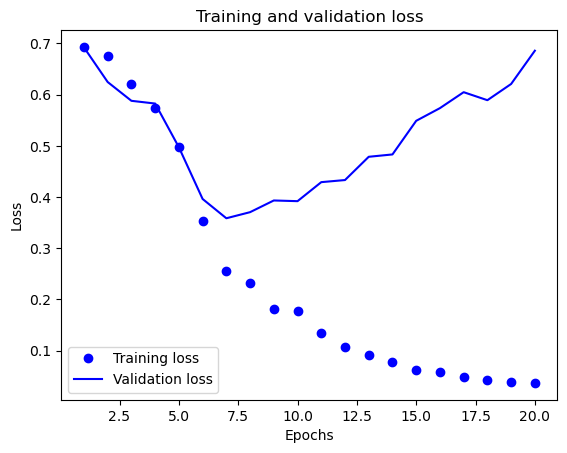

In [26]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

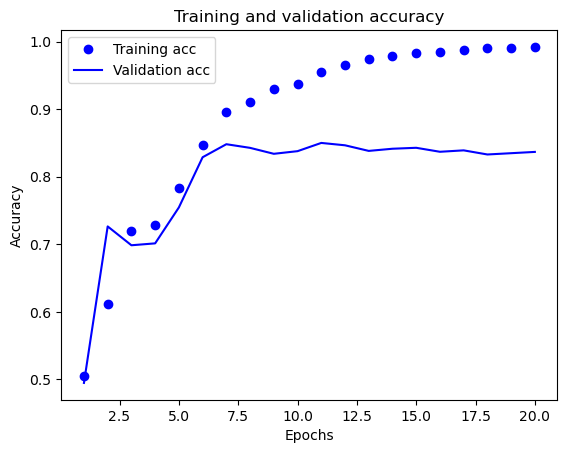

In [27]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

과적합(Overfitting이 발생한 것이 확인됨.

---

### 심화. Word2Vec 적용 
Embedding을 거쳤으므로 결과물인 워드 벡터들이 의미 공간상에 유의미한 형태로 학습되었다.<br>
여기에 워드 벡터를 다루는데 유용한 gensim 패키지를 사용할 것.
> [word2vec 이론](https://www.youtube.com/watch?v=sY4YyacSsLc&t=126s)

In [12]:
# 터미널에서 디렉터리 생성 및 gensim 패키지를 설치함

In [15]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [19]:
# 학습한 Embedding 파라미터를 파일에 써서 저장. 
word2vec_file_path = os.getenv('HOME')+'/Aiffel_Project/Data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씀.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

gensim에서 제공하는 패키지를 이용해, 위에 남긴 embedding 패러미터를 읽어서 word vector로 활용 가능

In [20]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([-0.01380186,  0.03994907, -0.01144682,  0.02752781,  0.04945885,
       -0.03719334,  0.04295421,  0.00917562,  0.00966991,  0.02597144,
        0.00335364,  0.03553641,  0.03994148,  0.04514929, -0.03491169,
        0.04970444], dtype=float32)

워드 벡터가 의미 벡터 공간상에 유의미하게 학습이 되었는지 확인하기 위해, 단어를 주고 그와 가장 유사한 단어를 뽑게 함

In [21]:
word_vectors.similar_by_word("love")

[('shelter', 0.8424227237701416),
 ('worse', 0.8184141516685486),
 ('bin', 0.800995945930481),
 ('perhaps', 0.7783967852592468),
 ("allen's", 0.7734225988388062),
 ('colony', 0.7619534730911255),
 ('valentine', 0.742603600025177),
 ('bette', 0.7317516207695007),
 ('public', 0.7290756106376648),
 ('dodgy', 0.7158185839653015)]

결과를 보면 알 수 있지만, 이정도 학습으로는 유사한 단어를 찾기 쉽지 않다.<br><br>



### 따라서 전이 학습(Transfer Learning)을 시도
따라서 구글에서 제공하는 Word2Vec이라는 사전학습된(Pretrained) 워드 임베딩 모델을 가져다 활용할 것<br>
Word2Vec은 무려 1억 개의 단어로 구성된 Google News dataset을 바탕으로 학습되었음.(총 300만 개의 단어를 각각 300차원의 벡터로 표현)

In [22]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/Aiffel_Project/Data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

300dim의 벡터로 이루어진 300만 개의 단어이므로, 이 단어 사전을 메모리에 모두 로딩하면 메모리 에러가 날 가능성이 크다.<br>
따라서 KeyedVectors.load_word2vec_format 메서드로 워드 벡터를 로딩할 때 가장 많이 사용되는 상위 100만 개만 limt으로 조건을 주고 로딩함.

In [23]:
word2vec.similar_by_word("love") #메모리 소비가 큰 작업

[('loved', 0.6907791495323181),
 ('adore', 0.6816874146461487),
 ('loves', 0.6618633270263672),
 ('passion', 0.6100709438323975),
 ('hate', 0.6003956198692322),
 ('loving', 0.5886634588241577),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547305345535278),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

유사한 단어를 도출해낸다.<br><br>

---

### 1-7. 이전 학습 모델의 Embedding Layer를 Word2Vec으로 교체해서 학습하기

In [24]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [25]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 580, 300)          3000000   
                                                                 
 conv1d (Conv1D)             (None, 574, 16)           33616     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 114, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 108, 16)           1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 8)                

In [26]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20


2022-09-19 23:47:21.782712: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-19 23:47:22.001680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.5275

2022-09-19 23:47:35.762688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 15s 439ms/step - loss: 0.6911 - accuracy: 0.5275 - val_loss: 0.6810 - val_accuracy: 0.5567
Epoch 2/20
30/30 [==============================] - 12s 407ms/step - loss: 0.6616 - accuracy: 0.6080 - val_loss: 0.6505 - val_accuracy: 0.6152
Epoch 3/20
30/30 [==============================] - 12s 397ms/step - loss: 0.5859 - accuracy: 0.7239 - val_loss: 0.5409 - val_accuracy: 0.7605
Epoch 4/20
30/30 [==============================] - 11s 375ms/step - loss: 0.4207 - accuracy: 0.8355 - val_loss: 0.3878 - val_accuracy: 0.8299
Epoch 5/20
30/30 [==============================] - 9s 305ms/step - loss: 0.2894 - accuracy: 0.8843 - val_loss: 0.3322 - val_accuracy: 0.8577
Epoch 6/20
30/30 [==============================] - 9s 297ms/step - loss: 0.2142 - accuracy: 0.9219 - val_loss: 0.3176 - val_accuracy: 0.8648
Epoch 7/20
30/30 [==============================] - 9s 292ms/step - loss: 0.1692 - accuracy: 0.9410 - val_loss: 0.3687 - val_accuracy: 0.8406
Epoch 8/20
30

In [27]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 6s - loss: 0.5670 - accuracy: 0.8482 - 6s/epoch - 7ms/step
[0.5670245885848999, 0.8481600284576416]
